The purpose of this notebook is to take all output artifacts from scenes in the experiements: 2021-05-12-BJ-PF-H2B-4OHT-AfterSort and to process them for downstream analysis. These output artifacts are generated by the Fiji custom plugin: CUSTOM PROCESS, and then fed into TrackMate for blob detection and particle linking. 

In [25]:
import sys
import os
import pandas as pd
import numpy as np
from importlib import reload
import time
from datetime import datetime

# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

# local import
sys.path.append("../")
from utils.trackmate import dataEngineering as _tm
from utils.visualization import generalPlots as _plot
from utils.trackmate import spatialAnalysis as _stat

In [26]:
"""
combine all outputs into a single dataframe
"""

reload(_tm)
ROOT = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/outputs/"

df_list = []

for _dir in os.listdir(ROOT):
    dir_path = f"{ROOT}{_dir}/"
    start = time.time()
    data = _tm.load_trackmate_dir(dir_path)
    df = _tm.merge_tracks_and_all(data)
    df = _tm.clean_up_trackSpots(df)
    df['TRACK_ID'] = f"{_dir}_" + df['TRACK_ID'].astype(str)
    df['SCENE'] = _dir
    end = time.time()
    print(f"{_dir} took {(end-start)/60:.3f} mins - {len(df)} rows")
    df_list.append(df)
    
df = pd.concat(df_list, ignore_index=True)
print(df.shape)
df.head()
    

C4 took 0.155 mins - 550431 rows
D7 took 0.146 mins - 512663 rows
C7 took 0.122 mins - 431302 rows
B3 took 0.141 mins - 468385 rows
D3 took 0.085 mins - 301432 rows
B4 took 0.149 mins - 487582 rows
C5 took 0.169 mins - 550372 rows
C3 took 0.136 mins - 453775 rows
D6 took 0.104 mins - 347463 rows
D5 took 0.116 mins - 382821 rows
B5 took 0.162 mins - 528405 rows
(5014631, 70)


,Label_x,ID,TRACK_ID,QUALITY,POSITION_X,POSITION_Y,POSITION_Z,POSITION_T,FRAME,RADIUS,...,TOTAL_ABSOLUTE_ANGLE_YZ,TOTAL_ABSOLUTE_ANGLE_ZX,STEP,NORMED_STEP,MEAN_INTENSITY01_SCALED,MEAN_INTENSITY02_SCALED,MEAN_INTENSITY03_SCALED,MEAN_INTENSITY04_SCALED,MEAN_INTENSITY_SCALED,SCENE
0,ID22432,22432,C4_0,5.518,1189.622,2690.774,0,0.000,0,10,...,3.142,1.571,0,0.000000,0.076016,0.185097,0.218159,0.077098,0.185097,C4
1,ID6061,6061,C4_0,5.734,1190.279,2691.973,0,1448.469,1,10,...,3.142,1.571,1,0.000004,0.056703,0.308242,0.270723,0.151456,0.308242,C4
2,ID17571,17571,C4_0,5.893,1190.071,2692.692,0,2896.938,2,10,...,3.142,1.571,2,0.000008,0.023996,0.299120,0.258299,0.238887,0.299120,C4
3,ID26984,26984,C4_0,6.387,1189.272,2691.550,0,4345.407,3,10,...,3.142,1.571,3,0.000012,0.118045,0.335721,0.015323,0.458649,0.335721,C4
4,ID12912,12912,C4_0,6.316,1188.536,2691.643,0,5793.876,4,10,...,3.142,1.571,4,0.000016,0.026247,0.365900,0.094871,0.283536,0.365900,C4


In [27]:
"""
make a back up to speed up development
"""

df2 = df.copy()

In [28]:
"""
rename some columns
"""

new_names = {
    'MEAN_INTENSITY01' : 'MEAN_GREEN_INTENSITY' ,
    'MEAN_INTENSITY02' : 'MEAN_BLUE_INTENSITY' ,
    'MEAN_INTENSITY03' : 'MEAN_RED_INTENSITY' ,
    'MEAN_INTENSITY04' : 'MEAN_OBLIQUE_INTENSITY' ,
    'MEAN_TRACK_INTENSITY01' : 'MEAN_GREEN_TRACK_INTENSITY' ,
    'MEAN_TRACK_INTENSITY02' : 'MEAN_BLUE_TRACK_INTENSITY',
    'MEAN_TRACK_INTENSITY03' : 'MEAN_RED_TRACK_INTENSITY',
    'MEAN_TRACK_INTENSITY04' : 'MEAN_OBLIQUE_TRACK_INTENSITY',
    'MEAN_INTENSITY01_SCALED' :  'MEAN_GREEN_INTENSITY_SCALED',
    'MEAN_INTENSITY02_SCALED' :  'MEAN_BLUE_INTENSITY_SCALED',
    'MEAN_INTENSITY03_SCALED' :  'MEAN_RED_INTENSITY_SCALED',
    'MEAN_INTENSITY04_SCALED' :  'MEAN_OBLIQUE_INTENSITY_SCALED',
    'Label_x' : 'LABEL',
}


df = df.rename(columns=new_names)
df = df.drop(['Label_y'], axis=1)
print(df.shape)
# list(df.columns)

(5014631, 69)


In [29]:
"""
Add experiment meta
"""

MYOD = {
    'C7' : '-',
    'D3' : '-',
    'B3' : '+',
    'B4' : '+',
    'B5' : '+',
    'D5' : '-',
    'D6' : '-',
    'D7' : '-',
    'C3' : '+',
    'C4' : '+',
    'C5' : '+',
}

serum = {
    'C7' : 'HS',
    'D3' : 'HS',
    'B3' : 'HS',
    'B4' : 'HS',
    'B5' : 'HS',
    'D5' : 'FBS',
    'D6' : 'FBS',
    'D7' : 'FBS',
    'C3' : 'FBS',
    'C4' : 'FBS',
    'C5' : 'FBS',
}

serum_con = {
    'C7' : '0.02',
    'D3' : '0.02',
    'B3' : '0.02',
    'B4' : '0.02',
    'B5' : '0.02',
    'D5' : '0.10',
    'D6' : '0.10',
    'D7' : '0.10',
    'C3' : '0.10',
    'C4' : '0.10',
    'C5' : '0.10',
}

df['MyoD'] = df['SCENE'].map(MYOD)
df['SERUM'] = df['SCENE'].map(serum)
df['SERUM_CONCENTRATION'] = df['SCENE'].map(serum_con)

df[['SERUM', 'SERUM_CONCENTRATION', ]].head()

,SERUM,SERUM_CONCENTRATION
0,FBS,0.10
1,FBS,0.10
2,FBS,0.10
3,FBS,0.10
4,FBS,0.10


In [30]:
test = df[df['SCENE'].isin(['C4', 'C5'])]

test['SCENE'].value_counts()

C4    550431
C5    550372
Name: SCENE, dtype: int64

In [ ]:
C4    550431
C5    550372

# Filtering 

(153999, 2)  unique tracks
(117336, 2)  unique tracks


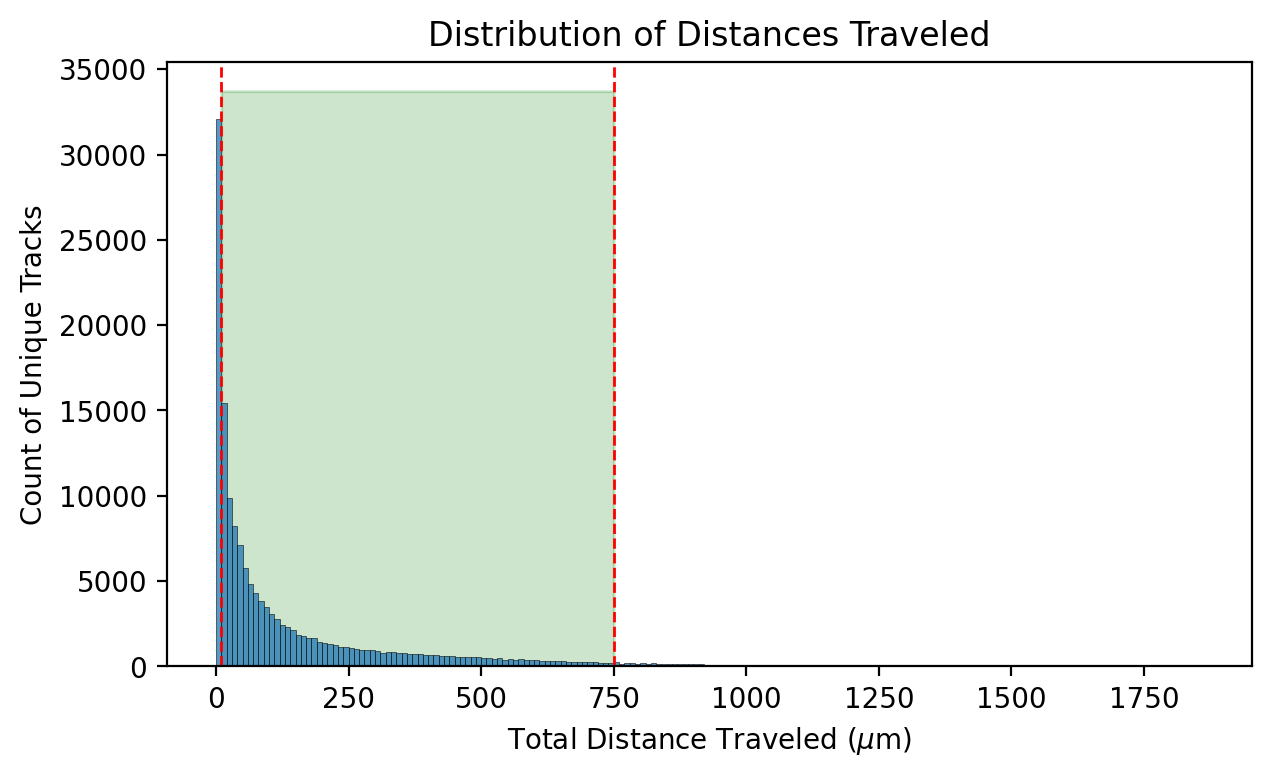

In [5]:
"""
cut the tracks below a certain length, or above a certain length
"""

MIN_CUT = 10
MAX_CUT = 750 

tmp = df[['TRACK_ID', 'TOTAL_DISTANCE_TRAVELED']].drop_duplicates()
print(tmp.shape, ' unique tracks')
matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['figure.figsize'] = (7, 4)

sns.histplot(data=tmp,
             x='TOTAL_DISTANCE_TRAVELED',
             binwidth=10)

plt.ylabel('Count of Unique Tracks')
plt.xlabel(r'Total Distance Traveled ($\mu$m)')
plt.title("Distribution of Distances Traveled")

plt.axvline(x=MIN_CUT, ls='--', c='r', lw=1)
plt.axvline(x=MAX_CUT, ls='--', c='r', lw=1)
plt.fill_betweenx(list(range(0, int(plt.ylim()[1]))), 
                  MIN_CUT, 
                  MAX_CUT, 
                  color='g', 
                  alpha=0.2)

mask = (tmp['TOTAL_DISTANCE_TRAVELED'] > MIN_CUT) & (tmp['TOTAL_DISTANCE_TRAVELED'] < MAX_CUT)
tmp = tmp[mask]
print(tmp.shape, ' unique tracks')

In [6]:
# sns.histplot(data=tmp,
#              x='TOTAL_DISTANCE_TRAVELED',
#              binwidth=10)

# plt.ylabel('Count of Unique Tracks')
# plt.xlabel(r'Total Distance Traveled ($\mu$m)')
# plt.title("Distribution of Distances Traveled")

In [7]:
"""
filter the original tracks based on TRACK_ID
"""

print(df.shape)
df = df[df['TRACK_ID'].isin(tmp['TRACK_ID'].unique())]
print(df.shape)


(5014631, 69)
(4223396, 69)


Text(0.5, 1.0, 'Distribution of Track Quality by Scene')

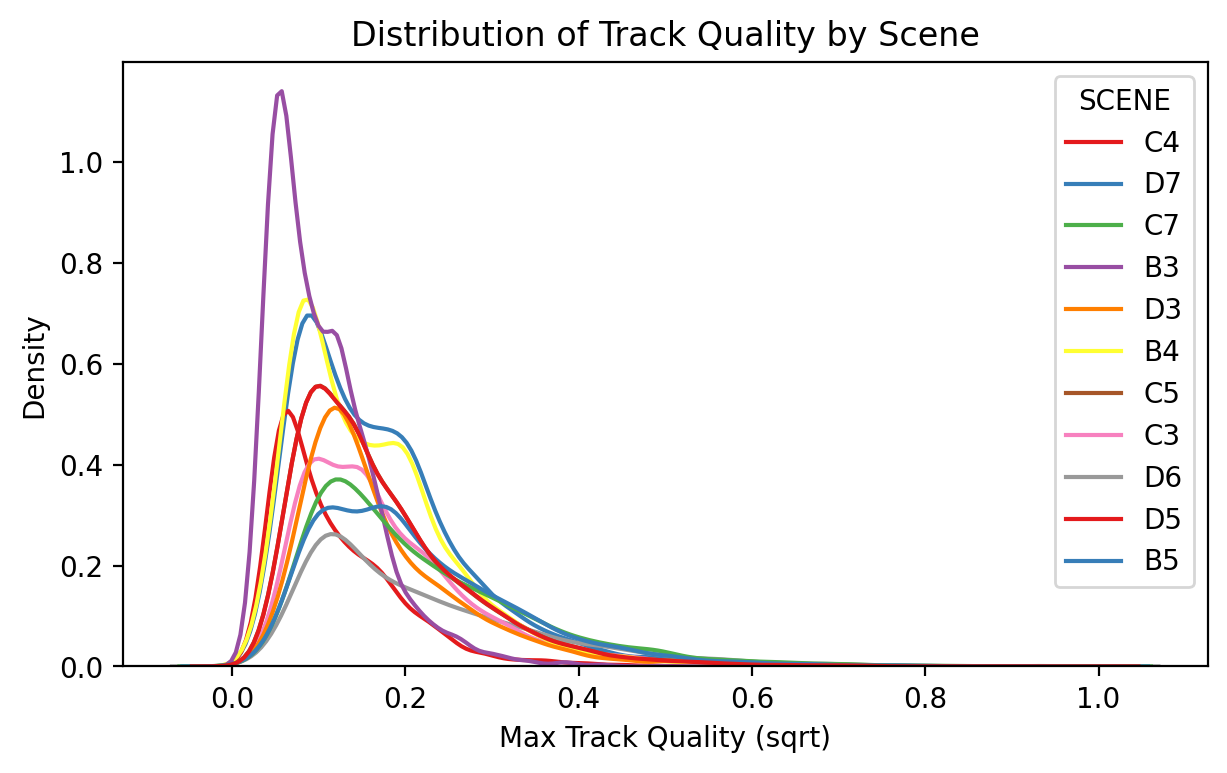

In [8]:
"""
look at track quality
"""

cols = [ 
    'TRACK_ID',
    'SCENE',
    'TRACK_MEAN_QUALITY',
    'TRACK_MAX_QUALITY',
    'TRACK_MIN_QUALITY',
    'TRACK_MEDIAN_QUALITY',
    'TRACK_STD_QUALITY'
]

tmp = df[cols].drop_duplicates()

tmp = _tm.min_max_norm(tmp, 'TRACK_MAX_QUALITY', 'SCENE')

tmp['qual'] = np.sqrt(tmp['TRACK_MAX_QUALITY_SCALED'])

sns.kdeplot(data=tmp,
            x='qual',
            hue='SCENE',
            palette='Set1')

plt.ylabel('Density')
plt.xlabel(r'Max Track Quality (sqrt)')
plt.title("Distribution of Track Quality by Scene")

In [9]:
stats = pd.DataFrame(tmp[[    'TRACK_MEAN_QUALITY',
    'TRACK_MAX_QUALITY',
    'TRACK_MIN_QUALITY',
    'TRACK_MEDIAN_QUALITY',
    'TRACK_STD_QUALITY']].describe())

stats = stats.round(3)
stats

,TRACK_MEAN_QUALITY,TRACK_MAX_QUALITY,TRACK_MIN_QUALITY,TRACK_MEDIAN_QUALITY,TRACK_STD_QUALITY
count,117336.000,117336.000,117336.000,117336.000,117336.000
mean,3.940,5.243,2.971,3.937,0.558
std,2.485,4.015,1.690,2.566,0.826
min,2.001,2.001,2.000,2.001,0.000
25%,2.456,2.946,2.056,2.428,0.180
50%,3.267,4.080,2.315,3.250,0.326
75%,4.463,5.958,3.196,4.443,0.639
max,78.169,187.167,37.499,100.762,55.419


In [10]:
"""
Filter out tracks whose max quality is very low
"""

MIN_CUT = 0.005

print(tmp.shape, ' unique tracks')
keep = tmp[tmp['TRACK_MAX_QUALITY_SCALED'] > MIN_CUT]
print(keep.shape, ' unique tracks')

df = df[df['TRACK_ID'].isin(keep['TRACK_ID'].unique())]
print(df.shape, ' total rows')

(117336, 9)  unique tracks
(101662, 9)  unique tracks
(4129064, 69)  total rows


Text(0.5, 1.0, 'Distribution of Mean Track SNR')

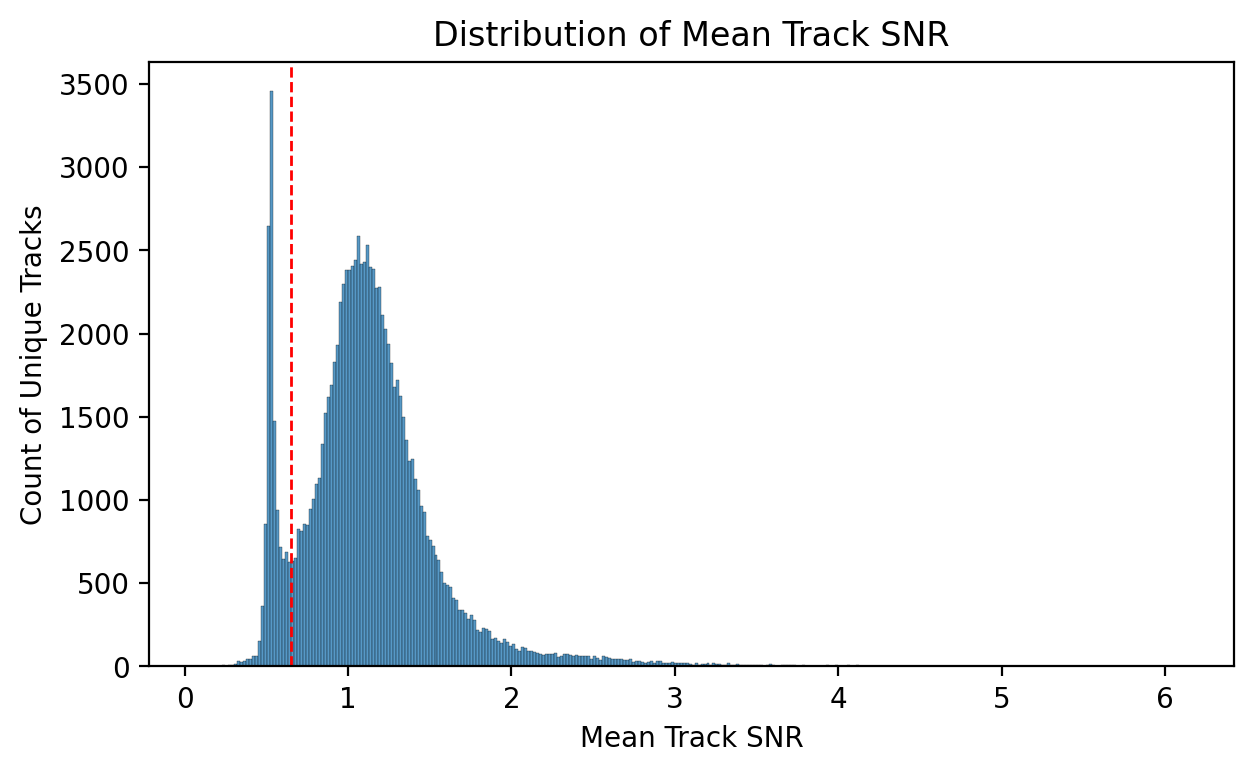

In [11]:
"""
look at track quality
"""
MIN_CUT = 0.65

cols = [ 
    'TRACK_ID',
    'SCENE',
    'SNR',
    'CONTRAST'
]

tmp = df[cols].drop_duplicates()

tmp = df.groupby('TRACK_ID', as_index=False).agg({'SCENE': 'first', 
                                                  'SNR':  ['mean', 'max', 'min', 'std']})
tmp.columns = ['_'.join(col).strip() for col in tmp.columns.values]
tmp.head()


sns.histplot(data=tmp,
            x='SNR_mean',
            palette='Set1')

plt.axvline(x=MIN_CUT, ls='--', c='r', lw=1)

plt.ylabel('Count of Unique Tracks')
plt.xlabel(r'Mean Track SNR')
plt.title("Distribution of Mean Track SNR")

In [12]:
MIN_CUT = 0.65

print(tmp.shape, ' unique tracks')
keep = tmp[tmp['SNR_mean'] > MIN_CUT]
print(keep.shape, ' unique tracks')

df = df[df['TRACK_ID'].isin(keep['TRACK_ID_'].unique())]
print(df.shape, ' total rows')

(101662, 6)  unique tracks
(88770, 6)  unique tracks
(3881581, 69)  total rows


### OUTPUT

In [13]:
today = datetime.today().strftime('%Y-%m-%d')
FILE_NAME = f"CLEANED_TRACKS{today}.csv"
save_dir = "/nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/"
full_path = f"{save_dir}{FILE_NAME}"
df.to_csv(full_path, index=False)

print(f"SAVED: {full_path}")

SAVED: /nfs/turbo/umms-indikar/shared/projects/live_cell_imaging/2021-05-12-BJ-PF-H2B-4OHT-AfterSort/analysis_files/CLEANED_TRACKS2021-06-24.csv
